In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd

df = pd.read_csv(r'spx_SABR.csv')

df['Date'] = pd.to_datetime(df['Date'], format='%y%m%d')
maturities = df['Date'].unique()

df

,Date,Strike,Moneyness,Bid,Midpoint,Ask,Last,Change,%Chg,Volume,Open Int,Vol/OI,IV,Time
0,2021-08-06,1200.0,0.73,3188.80,3190.85,3192.90,0.00,0.00,unch,0.0,0.0,0.00,7.48,NaN
1,2021-08-06,1400.0,0.68,2988.80,2990.85,2992.90,0.00,0.00,unch,0.0,0.0,0.00,6.63,NaN
2,2021-08-06,1600.0,0.64,2788.80,2790.85,2792.90,0.00,0.00,unch,0.0,0.0,0.00,5.89,NaN
3,2021-08-06,1800.0,0.59,2588.80,2590.85,2592.90,0.00,0.00,unch,0.0,0.0,0.00,5.24,NaN
4,2021-08-06,1900.0,0.57,2488.80,2490.85,2492.90,0.00,0.00,unch,0.0,0.0,0.00,4.95,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867,2022-03-31,6500.0,-0.48,0.10,0.33,0.55,1.00,1.00,unch,1.0,1.0,1.00,0.17,03/23/21
4868,2022-03-31,6600.0,-0.50,0.05,0.28,0.50,0.42,0.07,0.20,3.0,13.0,0.23,0.17,07/19/21
4869,2022-03-31,6700.0,-0.53,0.05,0.28,0.50,0.90,0.90,unch,4.0,5.0,0.80,0.00,03/23/21
4870,2022-03-31,6800.0,-0.55,0.10,0.28,0.45,0.20,-0.90,-0.82,1.0,13.0,0.08,0.00,07/21/21


In [11]:
import time
import datetime

import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

current_time = pd.Timestamp(year=2021, month=8, day=3, hour=12)

def delta_t(m):

    #now = pd.to_datetime(time.strftime('%Y-%m-%d %H:%M:%S', current_time))
    now = current_time
    delta_t = m - now
    year_dt = datetime.timedelta(365,0,0,0)

    return round(delta_t/year_dt, 6)


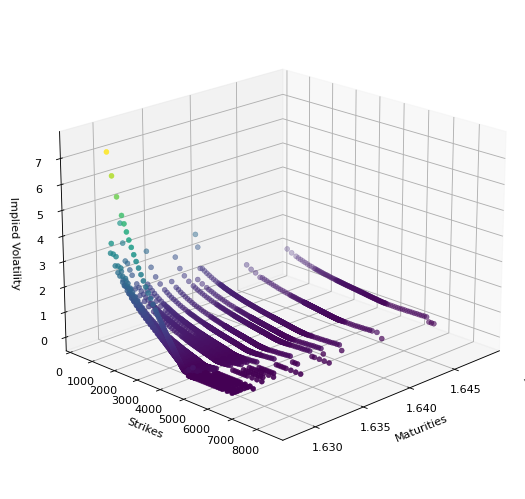

In [12]:
# 3d surface plot

polished_df = df[df["Strike"] >= 3500]
polished_df = polished_df[polished_df["Strike"] <= 5700]

x = pd.to_numeric(df["Date"])
y = df["Strike"]
z = df["IV"]

import yfinance as yf
spx = yf.Ticker("^SPX")

current_price = spx.info["regularMarketPrice"]



def plot3d(x, y, z, rng=current_price, angle=45, scatter=True):
    fig = plt.figure(figsize=(15, 8), dpi=80)

    ax = plt.axes(projection='3d')
    if scatter:
        ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=.5)
    else:
        ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none');



    ax.set_xlabel('Maturities')
    ax.set_ylabel('Strikes')
    ax.set_zlabel('Implied Volatility')

    ax.set_ylim((current_price - rng, current_price + rng))
    
    ax.invert_xaxis()
    ax.view_init(20, angle)
    

    plt.show()

plot3d(x, y, z, angle=45)  

In [8]:
#2d volatility smiles

def plot2d(x, y):
    fig = plt.figure(figsize=(6, 4), dpi=80)
    ax = fig.gca()

    ax.plot(x, y)

    ax.set_xlabel('Strikes')
    ax.set_ylabel('Implied Volatility')
    ax.set_xbound(4000, 6000)

    plt.show()


In [105]:
#volatility smile

def volatilitySmileSABR(maturity, shift=0, beta=.5):

    option = df[df["Date"] == maturity]
    dt = delta_t(pd.to_datetime(maturity))

    strikes = option["Strike"]
    fwd = current_price
    expiryTime = dt
    marketVols = option["IV"]*10**-2

    x = [0.1, 0.1, 0.1, .1]
    def f(params):

        alpha, beta, nu, rho = params

        alpha = max(alpha, 1e-8) # Avoid alpha going negative
        beta = max(beta, 1e-8) # Avoid beta going negative
        nu = max(nu, 1e-8) # Avoid nu going negative
        rho = max(rho, -0.999) # Avoid rhp going < -1.0
        rho = min(rho, 0.999) # Avoid rho going > 1.0

        vols = np.array([
        ql.sabrVolatility(strike + shift, fwd + shift, expiryTime, alpha, beta, nu, rho)
        for strike in strikes
        ])

        error = ((vols - np.array(marketVols))**2 ).mean() **.5

        return error

    cons = (
    {'type': 'ineq', 'fun': lambda x: x[0]},
    {'type': 'ineq', 'fun': lambda x: 0.99 - x[1]},
    {'type': 'ineq', 'fun': lambda x: x[1]},
    {'type': 'ineq', 'fun': lambda x: x[2]},
    {'type': 'ineq', 'fun': lambda x: 1. - x[3]**2}
    )


    result = minimize(f, x, constraints=cons)
    [alpha, beta, nu, rho] = result['x']


    newVols = [ql.sabrVolatility(strike, fwd, expiryTime, alpha, beta, nu, rho) for strike in strikes]
    
    return (newVols, result)


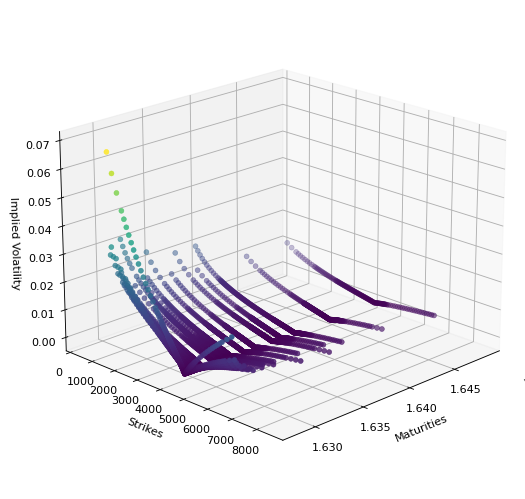

In [108]:
def volatilitySurfaceSABR():
    
    vol_surface_vector = []

    for m in maturities:
        volSABR = volatilitySmileSABR(maturity=m)
        smile = volSABR[0]
        vol_surface_vector.extend(smile)
    
    return vol_surface_vector


x = pd.to_numeric(df["Date"])
y = df["Strike"]
z = volatilitySurfaceSABR()

plot3d(x, y, z, angle=45)